In [1]:
# primary settings
state = 'OK'
district_type = 'CD'
level = 'vtd'
deviation = 0.01  # 0.10 means 10% means +/-5%

In [2]:
filepath = 'C:\\districting-data-2020\\'
filename = state + '_' + level + '.json'

from read import read_graph_from_json
G = read_graph_from_json( filepath + filename )

# total population
for i in G.nodes:
    G.nodes[i]['TOTPOP'] = G.nodes[i]['P0010001'] 
    
print("number of nodes, edges:",G.number_of_nodes(),G.number_of_edges())

number of nodes, edges: 1947 5325


In [3]:
from number_of_districts import number_of_districts

k = number_of_districts[state, district_type]
ideal_population = sum( G.nodes[i]['TOTPOP'] for i in G.nodes ) / k

import math
L = math.ceil(  ideal_population * (1-deviation/2) )
U = math.floor( ideal_population * (1+deviation/2) )

print("Using k, L, U =",k,L,U)

Using k, L, U = 5 787912 795829


In [4]:
# bidirected version of graph G
import networkx as nx
DG = nx.DiGraph(G)
DG._L = L
DG._U = U

In [5]:
# build optimization model to minimize inverse PP score
from district import build_single_district_mip 

m = build_single_district_mip(DG)

Set parameter Username

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2024-05-11
Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter IntFeasTol to value 1e-07


In [6]:
# solve the MISOCP
m.optimize(m._callback)

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-4790 CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 10654 rows, 12600 columns and 48556 nonzeros
Model fingerprint: 0x470cc8ca
Model has 1 quadratic constraint
Variable types: 3 continuous, 12597 integer (12597 binary)
Coefficient statistics:
  Matrix range     [4e-08, 1e+04]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e+05, 8e+05]
Presolve time: 0.09s
Presolved: 10654 rows, 12600 columns, 48556 nonzeros
Presolved model has 1 quadratic constraint(s)
Variable types: 3 continuous, 12597 integer (12597 binary)

Root relaxation: objective 0.000000e+00, 1926 iterations, 0.04 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd

  3324   527     cutoff   41         1.43020    0.92084  35.6%   290  404s
  3349   526    1.35795   25 2007    1.43020    0.92284  35.5%   294  409s
  3380   516    1.42700   19 1622    1.43020    0.93678  34.5%   297  414s
  3418   542     cutoff   23         1.43020    0.94719  33.8%   299  420s
  3478   553    1.39692   65 1827    1.43020    0.95167  33.5%   299  425s
  3519   554     cutoff   28         1.43020    0.96250  32.7%   301  431s
  3562   556     cutoff   18         1.43020    0.96451  32.6%   304  437s
  3616   555    1.37092   21 1606    1.43020    0.98221  31.3%   306  443s
  3681   548     cutoff   16         1.43020    0.99110  30.7%   306  450s
  3729   557    1.16103   31  817    1.43020    1.00173  30.0%   309  456s
  3782   558    1.41972   19 1924    1.43020    1.00867  29.5%   311  462s
H 3824   494                       1.3615658    1.02232  24.9%   313  462s
  3837   471     cutoff   19         1.36157    1.02589  24.7%   313  468s
  3898   456     cutoff  

In [7]:
print("The inverse Polsby-Popper score is",m.objval)
print("The Polsby-Popper score is",1.0/m.objval)

# retrieve the district and its population
district = [ i for i in G.nodes if m._x[i].x > 0.5 ] 
population = sum( G.nodes[i]["TOTPOP"] for i in district )

print("\nDistrict has this many nodes:",len(district))
print("And a population of:",population)
print("Is it connected?",nx.is_connected(G.subgraph(district)))

The inverse Polsby-Popper score is 1.343176125535633
The Polsby-Popper score is 0.7445040013655835

District has this many nodes: 256
And a population of: 791008
Is it connected? True


In [8]:
# Let's draw the district on a map
from export import draw_single_district
G._state = state
G._level = level

Exporting to png...


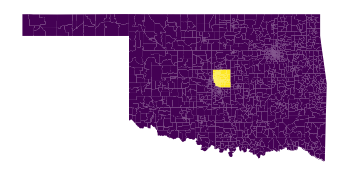

In [9]:
# State-wide view
draw_single_district( G, district, zoom=False )

Exporting to png...


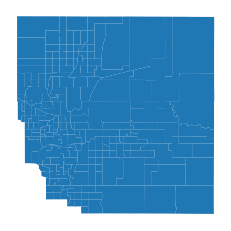

In [10]:
# District-only view
draw_single_district( G, district, zoom=True )

In [11]:
complement = [ i for i in G.nodes if i not in district ]
nx.is_connected(G.subgraph(complement))

True